<h1 style="color:Black;text-align:center">Saed - Call volumes and other stuff</h1>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
calls = pd.read_csv("../data/callsforservicefiltered.csv")

C:\Users\saadm\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2714: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
calls = calls[calls.rptonly != True]
calls = calls[calls.cancelled != True]
calls = calls[calls.nature != 'TRANSPORT TO ANIMAL SHELTER']
calls['calltime'] = pd.to_datetime(calls.calltime)
calls['year'] = calls.calltime.apply(lambda x: x.date().year)
calls['month'] = calls.calltime.apply(lambda x: x.date().month)
calls['dayOfMonth'] = calls.calltime.apply(lambda x: x.date().day)
calls['hour'] = calls.calltime.apply(lambda x: x.time().hour)
calls['minute'] = calls.calltime.apply(lambda x: x.time().minute)
calls['second'] = calls.calltime.apply(lambda x: x.time().second)
calls = calls.rename(columns={'calldow' : 'dayOfWeek'})
calls = calls.drop(columns = ['timeclose'], axis = 1)
calls = calls.drop(columns = ['statbeat','ra'])
calls

,calltime,callsource,city,nature,nature2,priority,rptonly,service,agency,district,...,secsar2lc,secsrt2dsp,secstr2lc,firstdisp,year,month,dayOfMonth,hour,minute,second
0,2012-07-01 00:01:15,SELF,G,TRAFFIC STOP,NaN,1,False,LAW,GCSD,SD3,...,651,0,0,S335,2012,7,1,0,1,15
1,2012-07-01 00:09:07,E911,G,HEMORRHAGE / LACERATIONS,NaN,4,False,EMS,EMS,B6,...,2454,43,965,M261,2012,7,1,0,9,7
3,2012-07-01 00:15:56,E911,W,SEIZURES-CONVULSIONS,NaN,1,False,EMS,EMS,B5,...,4522,30,3918,M2,2012,7,1,0,15,56
4,2012-07-01 00:17:20,E911,W,SEIZURES-CONVULSIONS,NaN,P,False,FIRE,GCF,ALAM,...,900,8,0,E44,2012,7,1,0,17,20
5,2012-07-01 00:19:24,E911,G,FALLS-BACK INJURIES(TRAUMATIC),NaN,3,False,EMS,EMS,B4B,...,0,10,0,M241,2012,7,1,0,19,24
6,2012-07-01 00:24:42,E911,G,SICK PERSON,NaN,4,False,EMS,EMS,B1,...,2295,29,1267,M211,2012,7,1,0,24,42
7,2012-07-01 00:29:23,SELF,ST,TRAFFIC STOP,NaN,1,False,LAW,GCSD,SD1,...,112,0,0,S314,2012,7,1,0,29,23
8,2012-07-01 00:30:03,W911,H,CHEST PAIN,NaN,1,False,EMS,EMS,B2,...,2090,17,1323,M221,2012,7,1,0,30,3
9,2012-07-01 00:33:11,PHONE,SU,DOMESTIC DISPUTE,NaN,1,False,LAW,GCSD,SD1,...,1109,102,0,S314,2012,7,1,0,33,11
10,2012-07-01 00:37:41,SELF,G,LEGAL PAPER / COMPLAINT,NaN,2,False,LAW,GCSD,GPD1,...,3734,0,0,S324,2012,7,1,0,37,41


<p>Here, we are just counting the number of <b>nulls</b> per each column, and displaying the datetype if it's not object.<br>If it is an object, we display the number of categories, in other words, the number of <b>distinct</b> values in that column.</p>

In [4]:
k = 0
for i in calls.columns:
    dtype = calls.dtypes[k].name
    if dtype == 'object':
        print i, ": nulls = ", len(calls.loc[calls[i].isnull()]), ", categories = ", \
        len(calls[i].astype('category').cat.categories)
    else:
        print i, ": nulls = ", len(calls.loc[calls[i].isnull()]), ", type = ", dtype
    k+=1

calltime : nulls =  0 , type =  datetime64[ns]
callsource : nulls =  3 , categories =  22
city : nulls =  681 , categories =  30
nature : nulls =  0 , categories =  259
nature2 : nulls =  986975 , categories =  167
priority : nulls =  243 , categories =  10
rptonly : nulls =  0 , type =  bool
service : nulls =  0 , categories =  5
agency : nulls =  0 , categories =  4
district : nulls =  80499 , categories =  63
gp : nulls =  83801 , categories =  857
primeunit : nulls =  429 , categories =  1213
cancelled : nulls =  0 , type =  bool
closecode : nulls =  0 , categories =  33
dayOfWeek : nulls =  0 , type =  int64
secs2rt : nulls =  0 , type =  int64
secs2di : nulls =  0 , type =  int64
secs2en : nulls =  0 , type =  int64
secs2ar : nulls =  0 , type =  int64
secs2tr : nulls =  0 , type =  int64
secs2lc : nulls =  0 , type =  int64
secsdi2en : nulls =  0 , type =  int64
secsdi2ar : nulls =  0 , type =  int64
secsar2tr : nulls =  0 , type =  int64
secsar2lc : nulls =  0 , type =  int64
s

In [5]:
print "The number of rows that have NaN values in district, statbeat, ra, and gp = ", \
len(calls.loc[calls['district'].isnull() & calls['gp'].isnull()])

The number of rows that have NaN values in district, statbeat, ra, and gp =  80488


In [6]:
total_calls = len(calls)
for city in calls.city.unique():
    if str(city) != 'nan':
        total_calls_city = len(calls.loc[calls.city == city])
    else:
        total_calls_city = len(calls.loc[calls.city.isnull()])
    percentage = total_calls_city*10000/total_calls
    print ("City '{}' has '{}' calls ({}.{}%).".format(city, total_calls_city, percentage/100, percentage%100))

City 'G' has '618589' calls (57.95%).
City 'W' has '30624' calls (2.86%).
City 'ST' has '15133' calls (1.41%).
City 'H' has '138414' calls (12.96%).
City 'SU' has '31617' calls (2.96%).
City 'CLI' has '6222' calls (0.58%).
City 'P' has '16288' calls (1.52%).
City 'ALAM' has '2326' calls (0.21%).
City 'J' has '53114' calls (4.97%).
City 'M' has '34346' calls (3.21%).
City 'JU' has '11451' calls (1.7%).
City 'B' has '29473' calls (2.76%).
City 'COL' has '10157' calls (0.95%).
City 'ROCK' has '2703' calls (0.25%).
City 'L' has '6154' calls (0.57%).
City 'OAK' has '16277' calls (1.52%).
City 'A' has '2153' calls (0.20%).
City 'K' has '6063' calls (0.56%).
City 'RAN' has '3535' calls (0.33%).
City 'GI' has '26739' calls (2.50%).
City 'E' has '1364' calls (0.12%).
City 'BUR' has '2272' calls (0.21%).
City 'REI' has '267' calls (0.2%).
City 'RAND' has '977' calls (0.9%).
City 'nan' has '681' calls (0.6%).
City 'FORS' has '369' calls (0.3%).
City 'DAVI' has '2' calls (0.0%).
City 'BURL' has '2

In [7]:
def plot_city_county(calls, mycity):
    plt.figure(figsize=(20,42))
    rng = np.arange(2012,2020)
    plt.subplot(5,2,1).set_title('Year - Guilford county')
    plt.xticks(rng)
    plt.xlim(rng.min()-0.7, rng.max()-0.3)
    plt.hist(calls.year, bins=rng-0.5, rwidth=0.75)

    rng = np.arange(1,14)
    plt.subplot(5,2,3).set_title('Month - Guilford county')
    plt.xticks(rng)
    plt.xlim(rng.min()-0.7, rng.max()-0.3)
    plt.hist(calls.month, bins=rng-0.5, rwidth=0.75, normed=True)

    rng = np.arange(1,33)
    plt.subplot(5,2,5).set_title('Day of Month - Guilford county')
    plt.xticks(rng)
    plt.xlim(rng.min()-0.7, rng.max()-0.3)
    plt.hist(calls.dayOfMonth, bins=rng-0.5, rwidth=0.75, normed=True)

    rng = np.arange(1,9)
    plt.subplot(5,2,7).set_title('Day of Week - Guilford county')
    plt.xticks(rng, ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
    plt.xlim(rng.min()-0.7, rng.max()-0.3)
    plt.hist(calls.dayOfWeek, bins=rng-0.5, rwidth=0.75, normed=True)

    rng = np.arange(1,25)
    plt.subplot(5,2,9).set_title('Hour - Guilford county')
    plt.xticks(rng)
    plt.xlim(rng.min()-0.7, rng.max()-0.3)
    plt.hist(calls.hour, bins=rng-0.5, rwidth=0.75, normed=True)
    
    rng = np.arange(2012,2020)
    plt.subplot(5,2,2).set_title('Year - "' + mycity + '" city')
    plt.xticks(rng)
    plt.xlim(rng.min()-0.7, rng.max()-0.3)
    plt.hist(calls.loc[calls.city == mycity].year, bins=rng-0.5, rwidth=0.75)

    rng = np.arange(1,14)
    plt.subplot(5,2,4).set_title('Month - "' + mycity + '" city')
    plt.xticks(rng)
    plt.xlim(rng.min()-0.7, rng.max()-0.3)
    plt.hist(calls.loc[calls.city == mycity].month, bins=rng-0.5, rwidth=0.75, normed=True)

    rng = np.arange(1,33)
    plt.subplot(5,2,6).set_title('Day of Month - "' + mycity + '" city')
    plt.xticks(rng)
    plt.xlim(rng.min()-0.7, rng.max()-0.3)
    plt.hist(calls.loc[calls.city == mycity].dayOfMonth, bins=rng-0.5, rwidth=0.75, normed=True)

    rng = np.arange(1,9)
    plt.subplot(5,2,8).set_title('Day of Week - "' + mycity + '" city')
    plt.xticks(rng, ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
    plt.xlim(rng.min()-0.7, rng.max()-0.3)
    plt.hist(calls.loc[calls.city == mycity].dayOfWeek, bins=rng-0.5, rwidth=0.75, normed=True)

    rng = np.arange(1,25)
    plt.subplot(5,2,10).set_title('Hour - "' + mycity + '" city')
    plt.xticks(rng)
    plt.xlim(rng.min()-0.7, rng.max()-0.3)
    plt.hist(calls.loc[calls.city == mycity].hour, bins=rng-0.5, rwidth=0.75, normed=True)

C:\Users\saadm\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


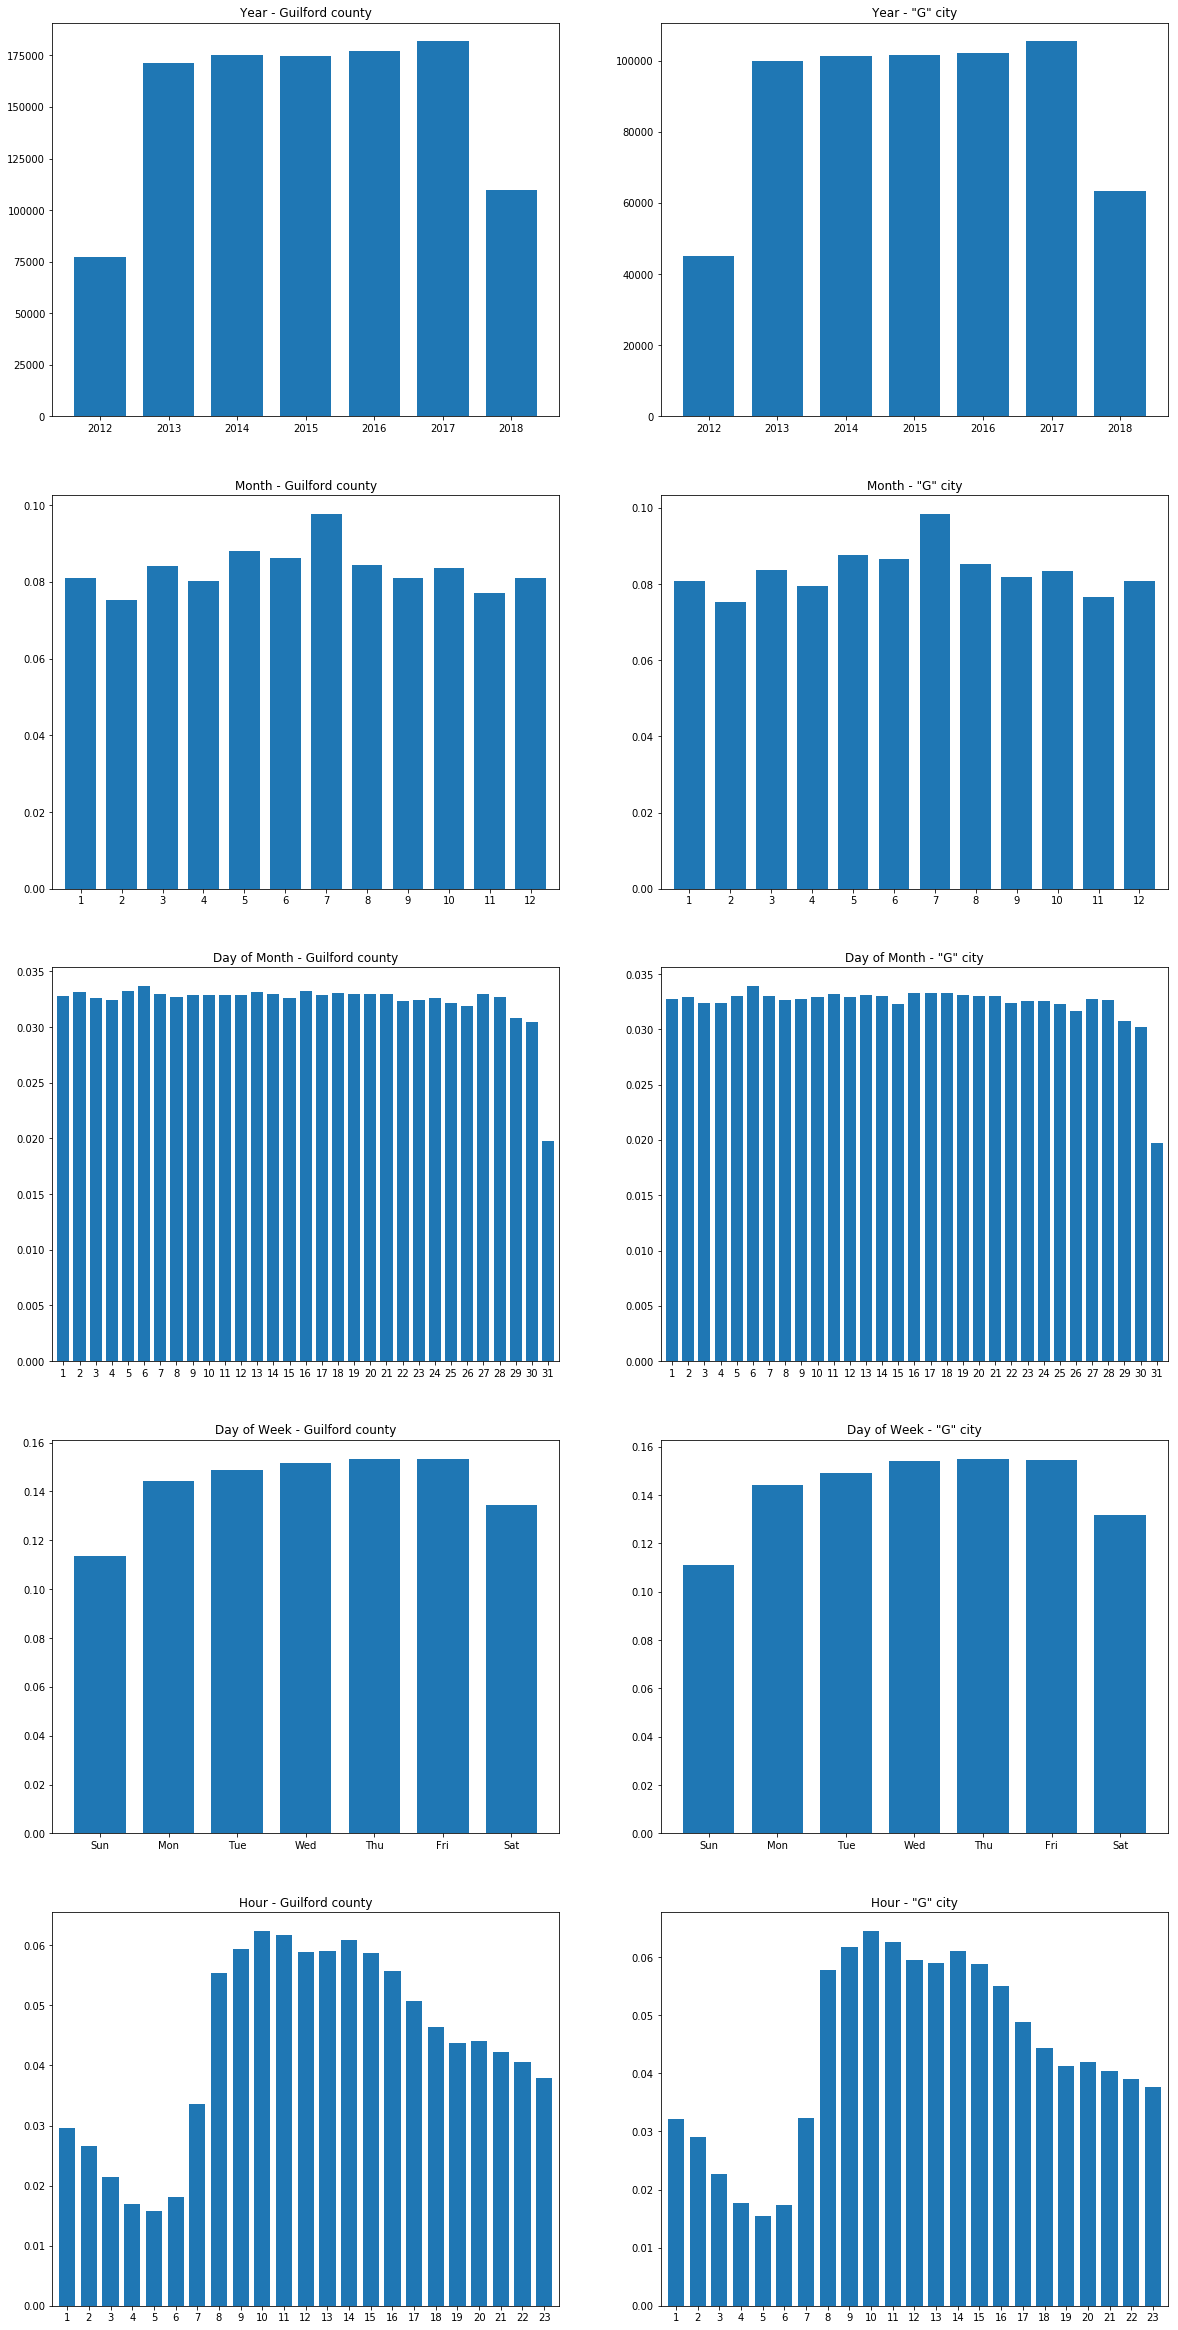

In [8]:
plot_city_county(calls, 'G')

To compare the previous graphs, we can use a statistical method called <b> Kolmogorov–Smirnov test </b>.

The lower the value it returns, the more of a chance that those sets are drawn from the same continuous distribution, for the sake of simplicity, we will call this value a 'mismatch percentage'.

In [9]:
from scipy import stats
for city in calls.city.unique():
    if str(city) != 'nan':
        total_calls_city = len(calls.loc[calls.city == city])
    else:
        continue
    print "The mismatch percentage with city '{0}' regarding call natures is {2} (For {1} calls).".format(city, total_calls_city, stats.ks_2samp(calls.loc[calls.city == city].nature.astype('category').cat.codes, calls.nature.astype('category').cat.codes)[0])

The mismatch percentage with city 'G' regarding call natures is 0.0759325348349 (For 618589 calls).
The mismatch percentage with city 'W' regarding call natures is 0.366947929283 (For 30624 calls).
The mismatch percentage with city 'ST' regarding call natures is 0.398722922117 (For 15133 calls).
The mismatch percentage with city 'H' regarding call natures is 0.391655093284 (For 138414 calls).
The mismatch percentage with city 'SU' regarding call natures is 0.364452805682 (For 31617 calls).
The mismatch percentage with city 'CLI' regarding call natures is 0.448055418274 (For 6222 calls).
The mismatch percentage with city 'P' regarding call natures is 0.387634696088 (For 16288 calls).
The mismatch percentage with city 'ALAM' regarding call natures is 0.756975754078 (For 2326 calls).
The mismatch percentage with city 'J' regarding call natures is 0.379919613405 (For 53114 calls).
The mismatch percentage with city 'M' regarding call natures is 0.345292679702 (For 34346 calls).
The mismatch

In [10]:
data = calls.groupby(['month','nature']).agg(['count'])['secsdi2ar']
for i in range(1,13):
    print i, " -- ", data.ix[i].sort_values('count', ascending=False).ix[0:5], '\n'

1  --                                  count
nature                               
TRAFFIC STOP                     9390
SICK PERSON                      6200
FALLS-BACK INJURIES(TRAUMATIC)   5189
BREATHING PROBLEMS               4359
CHEST PAIN                       3157 

2  --                                  count
nature                               
TRAFFIC STOP                     9148
SICK PERSON                      5424
FALLS-BACK INJURIES(TRAUMATIC)   4826
BREATHING PROBLEMS               3721
CHEST PAIN                       2769 

3  --                                  count
nature                               
TRAFFIC STOP                    10040
SICK PERSON                      5967
FALLS-BACK INJURIES(TRAUMATIC)   5117
BREATHING PROBLEMS               4202
CHEST PAIN                       3166 

4  --                                  count
nature                               
TRAFFIC STOP                     8688
SICK PERSON                      5555
FALLS-BACK INJUR

C:\Users\saadm\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


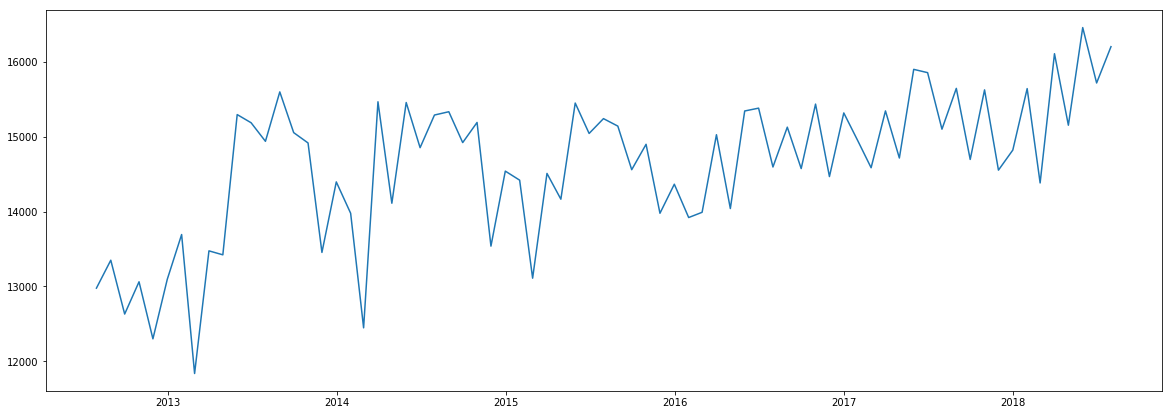

In [11]:
total_calls = calls.groupby(['year', 'month']).agg(['count'])['secsdi2ar']
plt.figure(figsize = (20,7))
t = pd.date_range('2012-07-01 00:00:00', periods=73, freq='1m')
plt.plot(t, total_calls['count'].tolist())

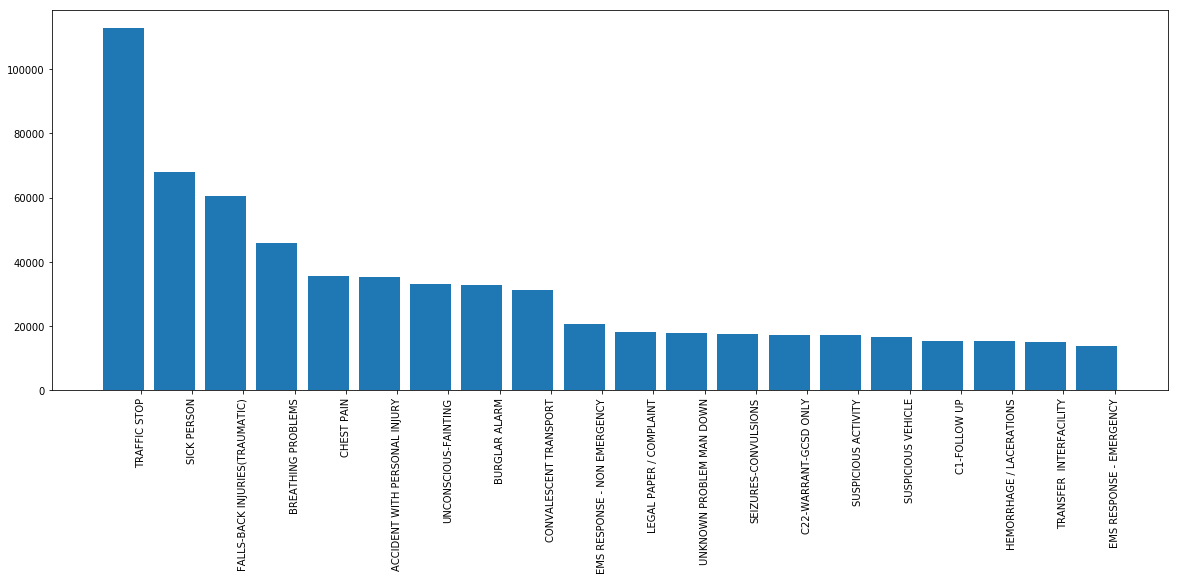

In [12]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

counts = Counter(calls.nature)

labels, values = zip(*counts.items())

indSort = np.argsort(values)[::-1][:20]

labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

bar_width = 0.35

plt.figure(figsize=(20,7))
plt.bar(indexes, values)
plt.xticks(indexes + bar_width, labels, rotation = 90)
plt.show()

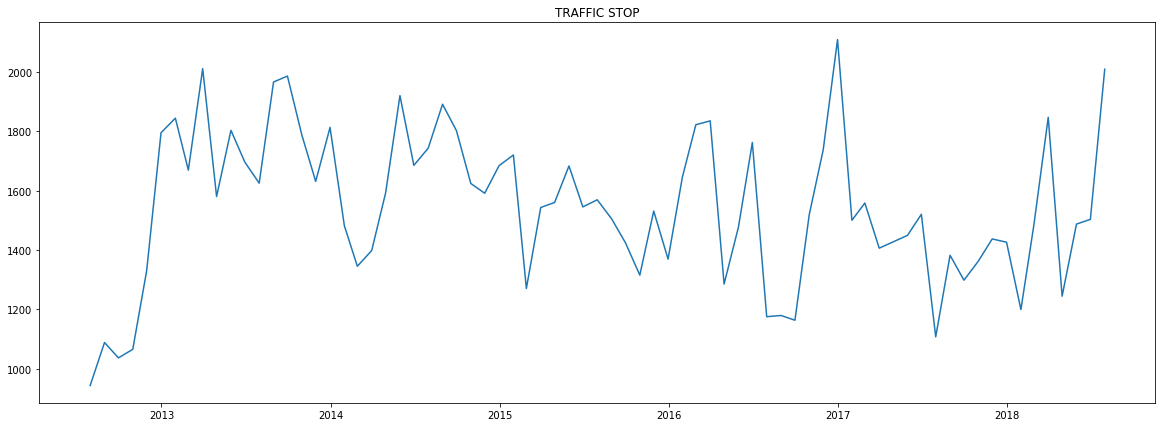

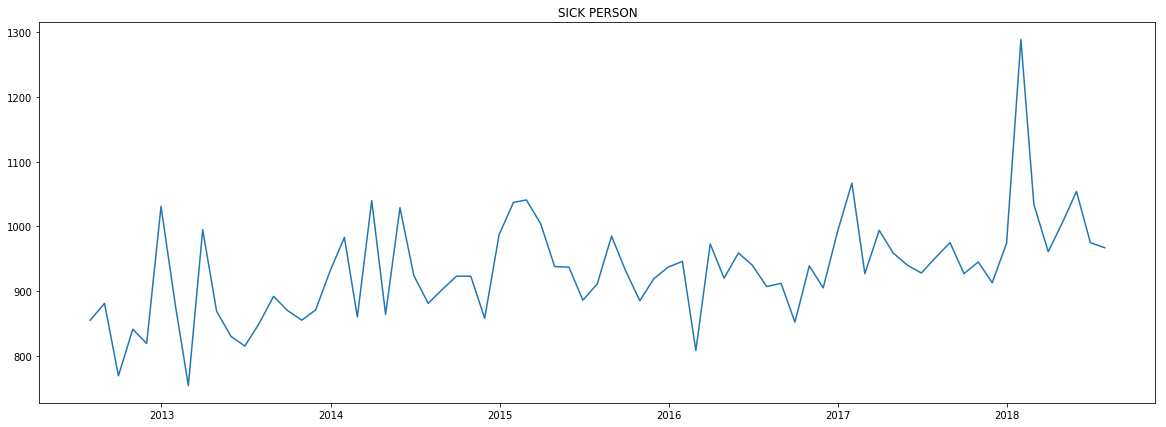

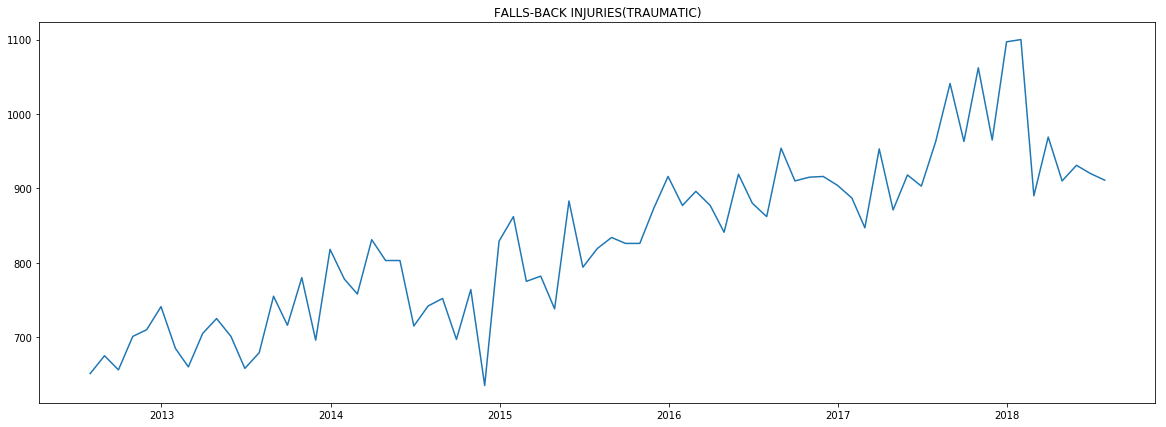

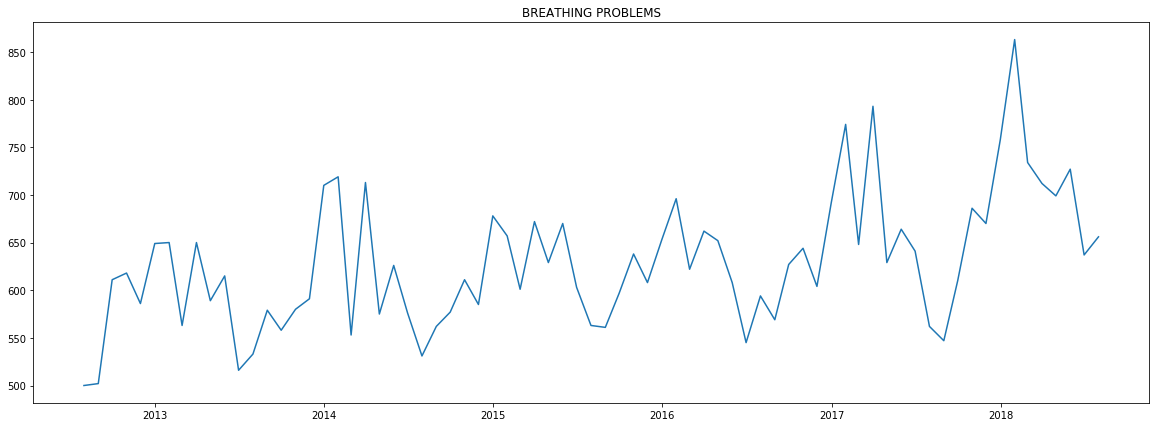

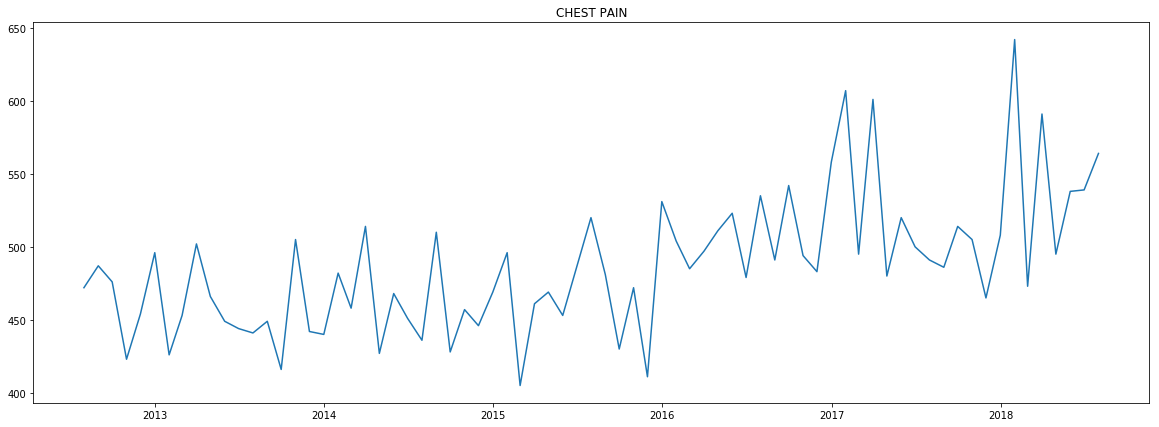

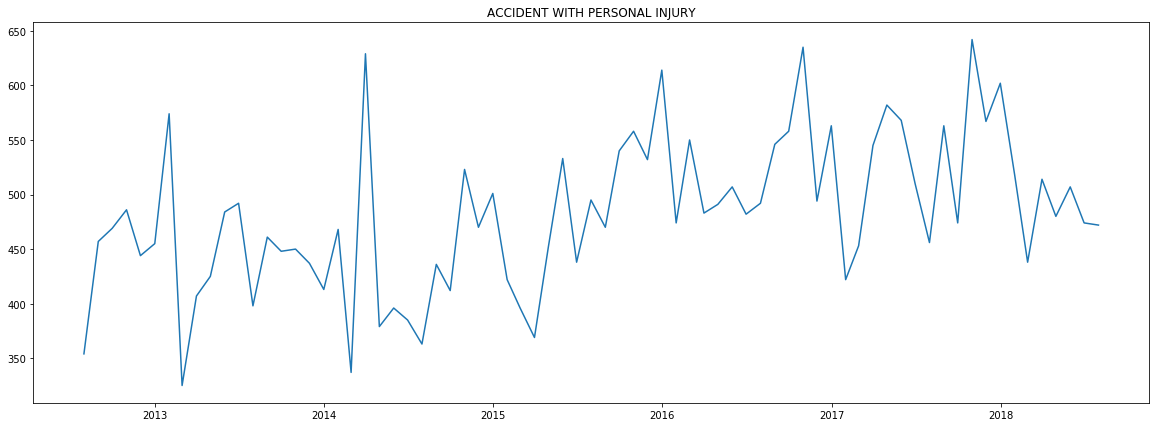

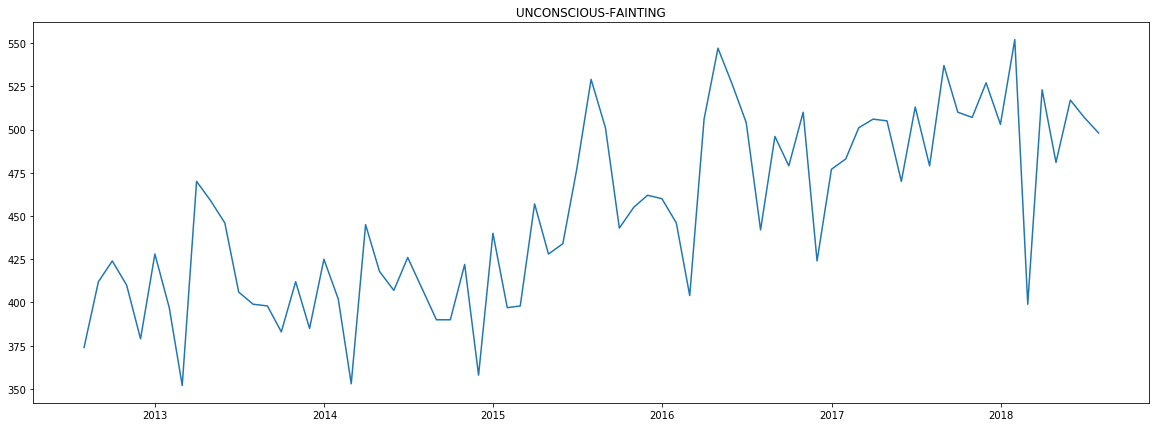

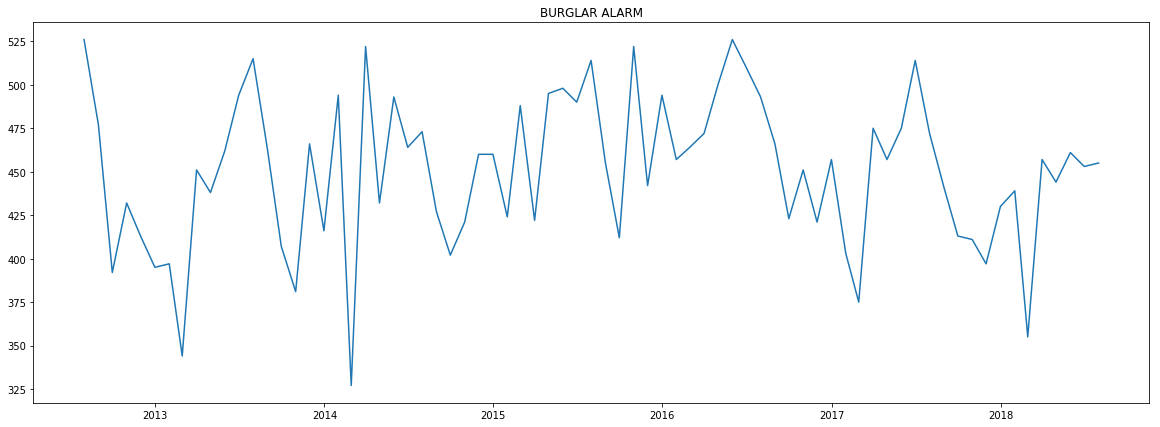

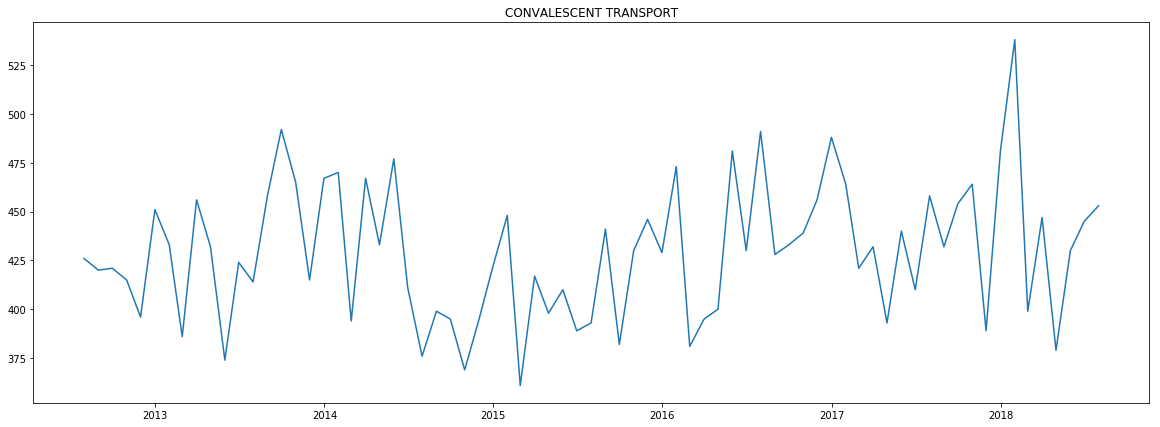

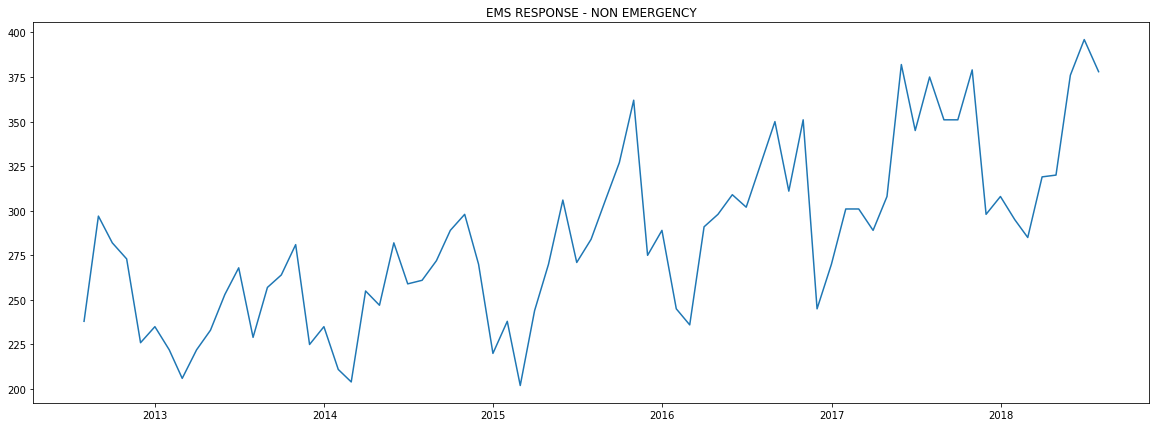

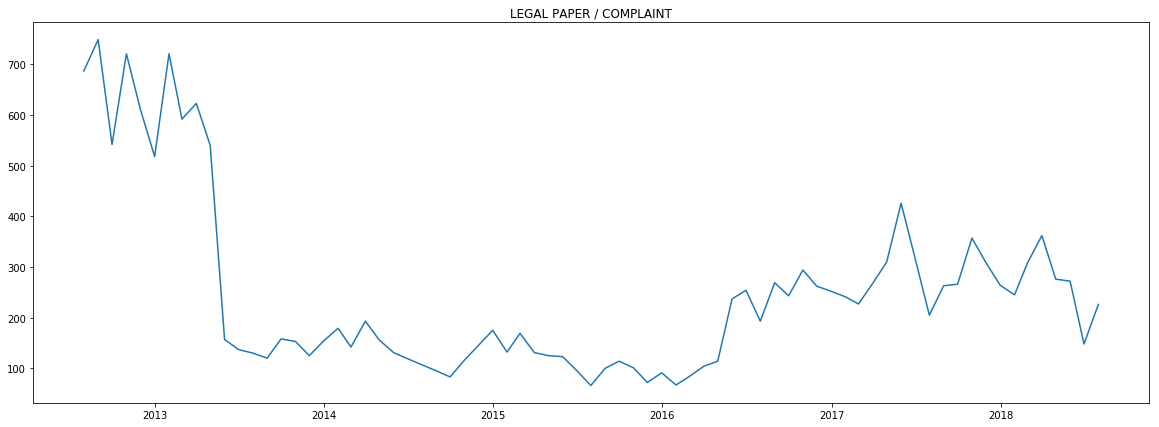

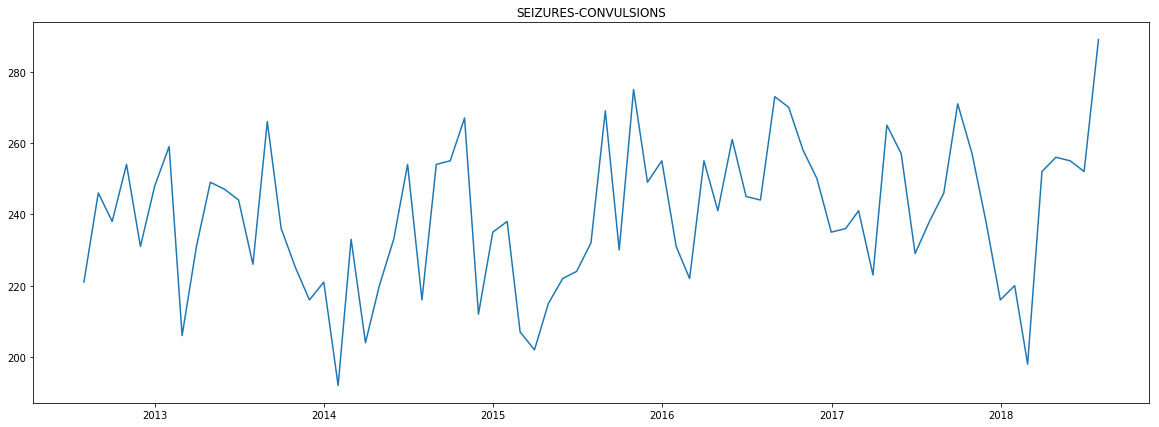

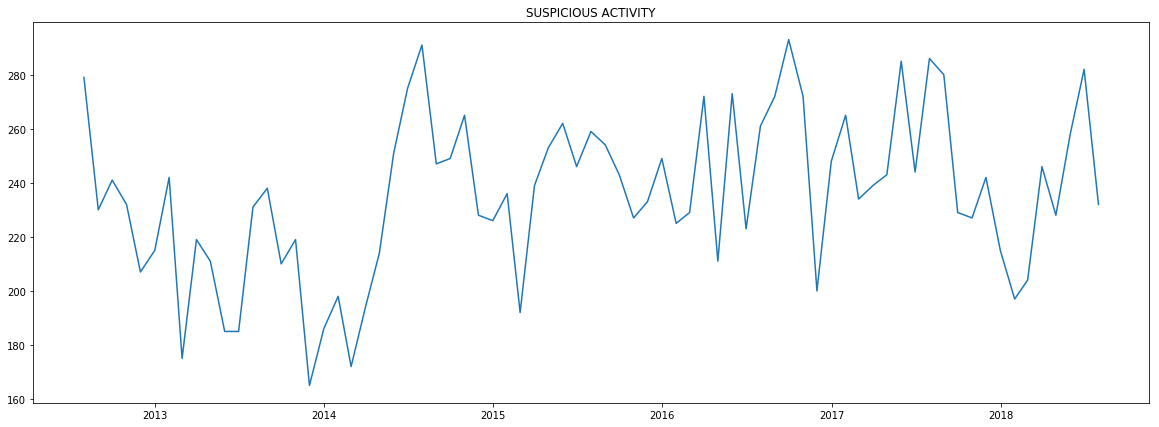

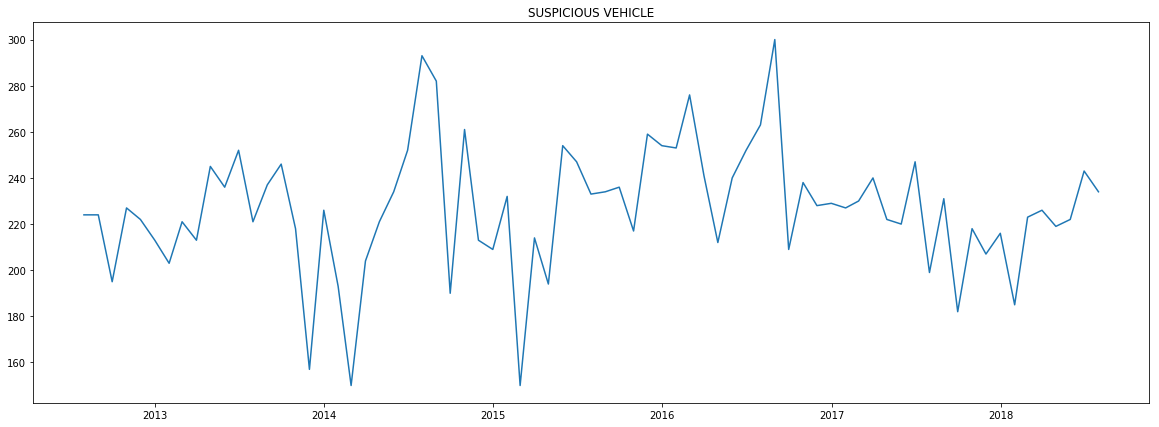

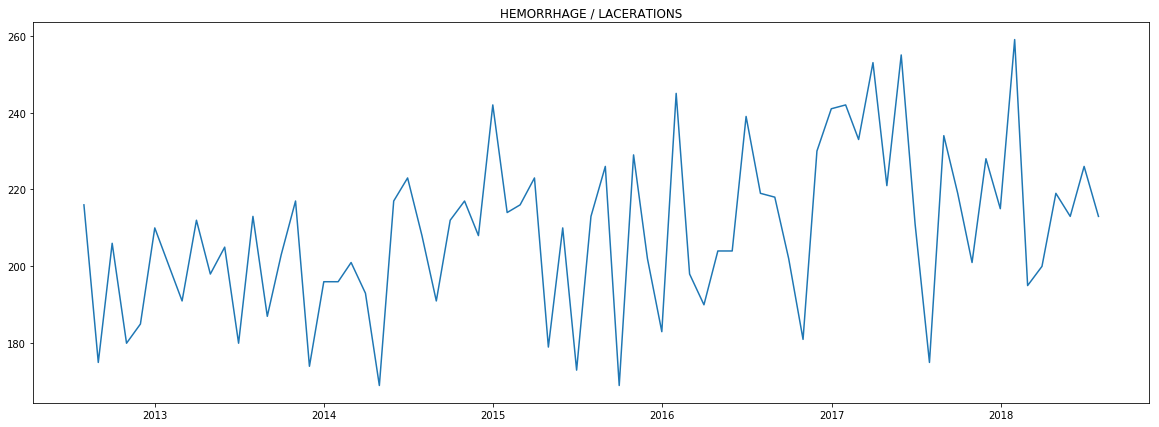

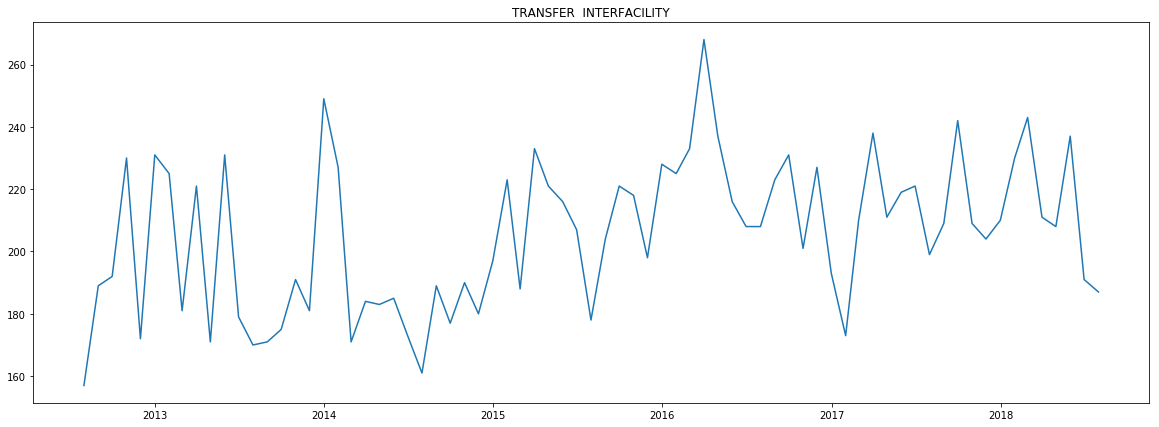

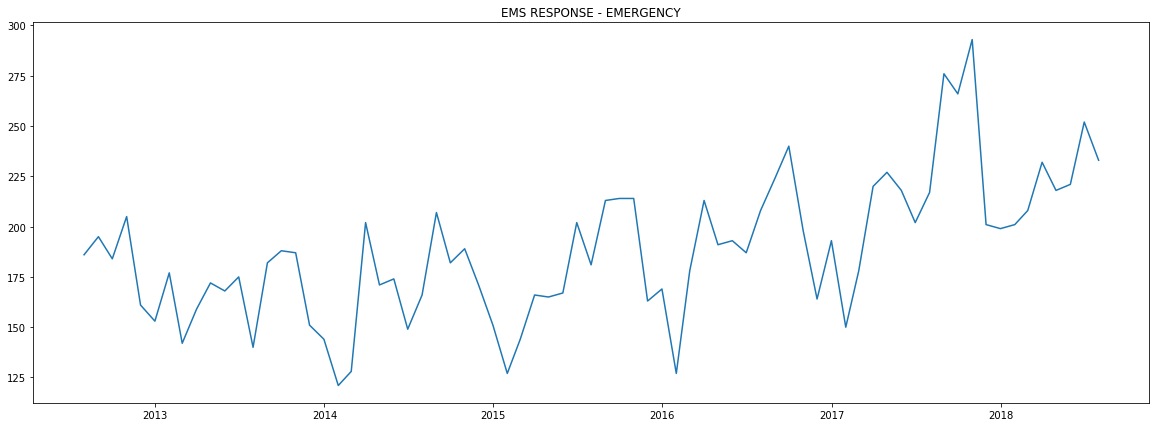

In [14]:
failed = []
average = calls.nature.value_counts() / (6 + 1.0/12) / 365
for i in average[:20].index:
    try:
        tmp = calls.loc[calls.nature == i].groupby(['year', 'month']).agg(['count'])['secsdi2ar']
        plt.figure(figsize = (20,7))
        t = pd.date_range('2012-07-01 00:00:00', periods=73, freq='1m')
        plt.title(i)
        plt.plot(t, tmp['count'].tolist())
    except:
        plt.close()
        failed.append(i)

In [15]:
calls.groupby(['year','month','dayOfMonth']).agg(['count'])['secsdi2ar'].groupby(['year','month']).agg('mean')['count']

year  month
2012  7        418.612903
      8        430.645161
      9        421.033333
      10       421.354839
      11       410.000000
      12       422.419355
2013  1        441.709677
      2        422.750000
      3        434.677419
      4        447.400000
      5        493.387097
      6        506.200000
      7        481.870968
      8        503.161290
      9        501.800000
      10       481.161290
      11       448.466667
      12       464.387097
2014  1        450.870968
      2        444.535714
      3        498.903226
      4        470.366667
      5        498.580645
      6        495.100000
      7        493.193548
      8        494.612903
      9        497.366667
      10       490.000000
      11       451.266667
      12       469.032258
                  ...    
2016  2        482.413793
      3        484.709677
      4        468.000000
      5        494.935484
      6        512.700000
      7        470.806452
      8        487.967742
